<a href="https://colab.research.google.com/github/RaisaAnika/model-confidence_CIFAR10/blob/main/CIS545_Fall22_ModelConfidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Model and Some Useful Starter Code

This starter code is to help you have a CIFAR-10 model that is trained on the whole dataset. You will also find some helper functions for splitting the dataset into $n$ disjoint sets (from which you can train individual models that will serve in the ensemble).

The CIFAR10 dataset contains 60K color images in 10 classes, with 6K images in each class. The dataset is divided into 50K training images and 10K testing images. The classes are mutually exclusive and there is no overlap between them. The 10 classes are ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'].




In [41]:
import tensorflow as tf
from keras.models import Model   
from keras.layers import *
import matplotlib.pyplot as plt

In [42]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, \
Dense, Input, Activation, MaxPool2D
from tensorflow.keras import Model

import sklearn.metrics

from numpy.random import default_rng
rng = default_rng()
AUTO = tf.data.AUTOTUNE

In [43]:
!pip install tensorflow_privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.3.4-cp37-cp37m-manylinux1_x86_64.whl (11.5 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [44]:
!pip install tensorflow-privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
###Tensorflow attack libraries

from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack as mia 
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

In [46]:
# download CIFAR-10 dataset and split it into train and test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [47]:
print(x_train.shape[0])

50000


In [48]:
print(x_test.shape[0])

10000


In [49]:
print(y_train)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [50]:
# normalze pixel values to be in the range [0,1] instead of [0, 255]
x_train, x_test= x_train/ 255.0, x_test / 255.0



In [51]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.8.4 requires matplotlib~=3.3.4, but you have matplotlib 3.1.3 which is incompatible.


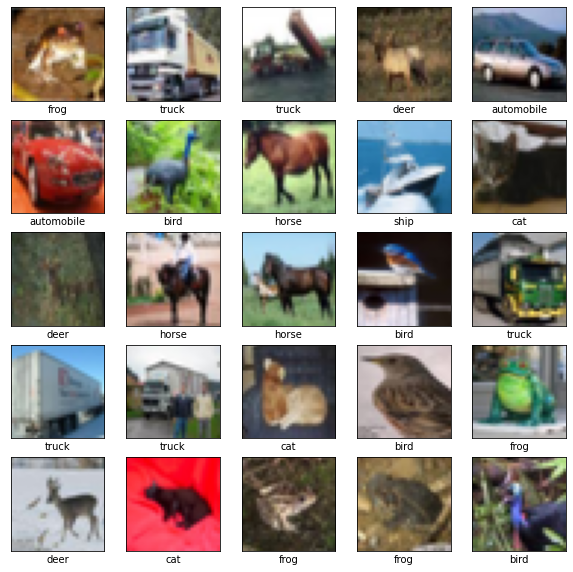

In [52]:
# let's check what individual samples in the training data look like just for verification

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i][0]])
plt.show()



In [53]:
def define_model():
  """ This model is fairly simple, feel free to play with this part in pursuit of a better accuracy architecture.
  """
  shape = (32, 32, 3)
  input = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(input)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(10)(x)
  model = Model(input, x)
  return model

In [54]:
# check model summary
model = define_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          3692

In [55]:
##divide xtrain n ytrain to 5 DISJOINT subsets
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical


M=5

X=x_train
Y=y_train
for i in range(0,M):
  K=M-i
  if(K>=2):
    train=X
    test=Y
    skf = StratifiedKFold(n_splits=K)
    skf.get_n_splits(X, Y)
    #print(skf)
    for train_index, test_index in skf.split(X, Y):
       #print(X.shape)
       X,globals()['x_train_split%s' % i]=train[train_index], train[test_index]
       Y,globals()['trainy_split%s' % i]=test[train_index], test[test_index]
       y_hot=globals()['trainy_split%s' % i]
       y_hot=to_categorical(y_hot)
       globals()['y_train_split%s' % i]=y_hot
       #X=train
       #Y=test
  elif K==1:
    globals()['x_train_split%s' % i]=X
    globals()['trainy_split%s' % i]=Y
    y_hot=to_categorical(Y)
    globals()['y_train_split%s' % i]=y_hot

In [113]:
## 5 disjoint set of the train data
d1_data = x_train_split0
d1_label = y_train_split0
d2_data= x_train_split1
d2_label=y_train_split1
d3_data= x_train_split2
d3_label=y_train_split2
d4_data= x_train_split3
d4_label=y_train_split3
d5_data= x_train_split4
d5_label=y_train_split4

In [106]:
d1_data.shape

(10000, 32, 32, 3)

In [109]:
d1_label.shape

(10000, 10)

In [58]:
skf.split(X, Y)

<generator object _BaseKFold.split at 0x7f300756e350>

In [112]:
# specify parameters for model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



In [114]:
## fitting d1

# train the model with d1
history1 = model.fit(d1_data, d1_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=10)
history1

Epoch 1/10


InvalidArgumentError: ignored

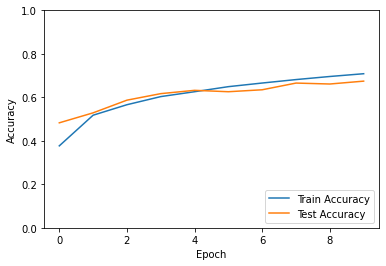

In [60]:
# evalaute model accuracy
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [61]:
# predict probabilities
import numpy as np
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)




313/313 [==============================] - 3s 8ms/step


In [62]:
print(predictions)

[[7.9614930e-03 2.3346742e-04 1.3303562e-02 ... 7.6868664e-04
  5.6847211e-02 9.7118238e-05]
 [6.4443752e-02 5.9185125e-02 3.4087585e-05 ... 1.8854266e-06
  8.7535369e-01 9.6522982e-04]
 [7.4399665e-02 3.7340298e-02 3.8874943e-03 ... 2.4766154e-03
  7.7452165e-01 1.0192470e-01]
 ...
 [4.5470682e-05 1.1802427e-05 2.0579373e-02 ... 7.1526421e-03
  2.1708318e-05 2.4807237e-05]
 [2.5013340e-01 1.3988218e-01 9.3348995e-02 ... 3.2693457e-02
  3.3711747e-03 1.1332779e-02]
 [1.3864179e-05 2.8377985e-06 2.9562279e-03 ... 9.3290013e-01
  1.5898656e-06 1.5557032e-06]]


In [63]:
index =0
for p in predictions:
  print( p, np.argmax(p),y_test[index])
  index+=1

Streaming output truncated to the last 5000 lines.
[3.53380165e-04 1.50585993e-05 5.30252829e-02 1.23377502e-01
 1.11639336e-01 1.15290798e-01 5.94888330e-01 1.21075660e-03
 1.88724909e-04 1.07672022e-05] 6 [2]
[0.03660987 0.30369297 0.0134731  0.01804332 0.00503316 0.01982938
 0.00839181 0.20469171 0.05536047 0.33487415] 9 [9]
[3.1174854e-03 8.8776171e-01 2.4204548e-03 3.0658506e-02 1.5825037e-03
 3.8007097e-03 3.3157554e-02 5.9024873e-04 7.8728991e-03 2.9037869e-02] 1 [1]
[2.1656514e-04 1.5306164e-04 9.5774449e-02 3.6570370e-02 4.3552443e-01
 1.0512101e-02 4.1892204e-01 2.2911422e-03 2.7191436e-05 8.4848853e-06] 4 [2]
[8.6501670e-05 2.3379219e-04 1.5476561e-01 7.3922433e-02 1.4705116e-01
 5.1337805e-02 5.6678355e-01 5.7684556e-03 1.7097196e-05 3.3574022e-05] 6 [6]
[6.6937453e-01 9.7153140e-03 2.3053674e-02 9.9978726e-03 1.7729454e-02
 5.7786098e-03 1.6790970e-03 5.1847682e-04 2.4685565e-01 1.5297368e-02] 0 [0]
[2.0865657e-04 6.9745380e-05 3.9899159e-02 6.1626971e-02 1.1014247e-01
 6.

In [64]:
predictions_trained_data = probability_model.predict(x_train)

1563/1563 [==============================] - 13s 8ms/step


In [65]:
print(predictions_trained_data)

[[4.80542258e-05 2.33572173e-05 9.76388305e-02 ... 7.30970874e-03
  1.11420413e-04 7.35370861e-07]
 [6.37041265e-03 2.20138058e-02 2.29906174e-03 ... 9.64347739e-03
  4.85210010e-04 9.55836296e-01]
 [1.80660840e-02 1.98947638e-02 9.97223053e-03 ... 4.90730666e-02
  7.52338674e-03 8.54821920e-01]
 ...
 [1.32868504e-02 2.31158268e-02 1.01394951e-03 ... 3.60763352e-03
  3.24534401e-02 9.25116658e-01]
 [1.15131095e-01 8.19719136e-01 6.43594190e-04 ... 2.32314298e-04
  2.58009005e-02 3.69509645e-02]
 [6.40807629e-01 9.02546942e-02 1.22067146e-01 ... 1.77303571e-02
  6.13574870e-02 7.63118872e-03]]


In [66]:
#Attack Model Build-up

prob_train = predictions_trained_data
prob_test= predictions


In [67]:
yt=y_train[0:5000]
ys=y_test[5000:10000]

In [68]:
len(y_test)

10000

In [69]:
len(y_train)

50000

In [70]:
(unique, counts) = np.unique(ys, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[  0, 512],
       [  1, 495],
       [  2, 488],
       [  3, 503],
       [  4, 493],
       [  5, 512],
       [  6, 509],
       [  7, 505],
       [  8, 496],
       [  9, 487]])

In [71]:
# define what variables our attacker should have access to

attack_input = AttackInputData(
  logits_train = prob_train,
  logits_test = prob_test,
  #loss_train = loss_train,
  #loss_test = loss_test,
  labels_train =yt,
  labels_test =ys
)

In [72]:
len(prob_train)

50000

In [73]:
len(yt)

5000

In [74]:
attack_input

AttackInputData(logits_train=array([[4.80542258e-05, 2.33572173e-05, 9.76388305e-02, ...,
        7.30970874e-03, 1.11420413e-04, 7.35370861e-07],
       [6.37041265e-03, 2.20138058e-02, 2.29906174e-03, ...,
        9.64347739e-03, 4.85210010e-04, 9.55836296e-01],
       [1.80660840e-02, 1.98947638e-02, 9.97223053e-03, ...,
        4.90730666e-02, 7.52338674e-03, 8.54821920e-01],
       ...,
       [1.32868504e-02, 2.31158268e-02, 1.01394951e-03, ...,
        3.60763352e-03, 3.24534401e-02, 9.25116658e-01],
       [1.15131095e-01, 8.19719136e-01, 6.43594190e-04, ...,
        2.32314298e-04, 2.58009005e-02, 3.69509645e-02],
       [6.40807629e-01, 9.02546942e-02, 1.22067146e-01, ...,
        1.77303571e-02, 6.13574870e-02, 7.63118872e-03]], dtype=float32), logits_test=array([[7.9614930e-03, 2.3346742e-04, 1.3303562e-02, ..., 7.6868664e-04,
        5.6847211e-02, 9.7118238e-05],
       [6.4443752e-02, 5.9185125e-02, 3.4087585e-05, ..., 1.8854266e-06,
        8.7535369e-01, 9.6522982e-04]

In [75]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = False,
    by_percentiles = False,
    by_classification_correctness = True)

In [76]:
# define the type of attacker model that we want to use
attack_type = [
    AttackType.MULTI_LAYERED_PERCEPTRON
]

In [77]:
len(y_train)

50000

In [78]:
### MMD+MiXUP - regularisation based defence
n = len(y_train)
val_samples = 2000
x_val, y_val = x_train[30000:40000], y_train[30000:40000] ### validation dataset defined


In [79]:
print(x_val)

[[[[0.69803922 0.69019608 0.74117647]
   [0.69803922 0.69019608 0.74117647]
   [0.69803922 0.69019608 0.74117647]
   ...
   [0.66666667 0.65882353 0.70588235]
   [0.65882353 0.65098039 0.69411765]
   [0.64705882 0.63921569 0.68235294]]

  [[0.70588235 0.69803922 0.74901961]
   [0.70196078 0.69411765 0.74509804]
   [0.70588235 0.69803922 0.74901961]
   ...
   [0.67843137 0.67058824 0.71372549]
   [0.67058824 0.6627451  0.70588235]
   [0.65882353 0.65098039 0.69411765]]

  [[0.69411765 0.68627451 0.7372549 ]
   [0.69411765 0.68627451 0.7372549 ]
   [0.69803922 0.69019608 0.74117647]
   ...
   [0.67058824 0.6627451  0.70588235]
   [0.6627451  0.65490196 0.69803922]
   [0.65490196 0.64705882 0.69019608]]

  ...

  [[0.43921569 0.41960784 0.41960784]
   [0.44313725 0.42745098 0.42352941]
   [0.44705882 0.43137255 0.43137255]
   ...
   [0.39215686 0.38039216 0.36862745]
   [0.38431373 0.36862745 0.36470588]
   [0.39607843 0.37254902 0.37254902]]

  [[0.43921569 0.4        0.39607843]
   [0.4

In [80]:
batch_size = 128
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)


In [81]:
len(val_ds)

79

In [82]:

for images, labels in val_ds:  # only take first element of dataset
    x_val = images.numpy()
    y_val = labels.numpy()

In [83]:
x_val

array([[[[0.78823529, 0.83529412, 0.89803922],
         [0.78823529, 0.83529412, 0.92941176],
         [0.79215686, 0.83921569, 0.9372549 ],
         ...,
         [0.43529412, 0.51372549, 0.6745098 ],
         [0.29803922, 0.38431373, 0.54901961],
         [0.25098039, 0.37254902, 0.53333333]],

        [[0.80784314, 0.85490196, 0.89803922],
         [0.78823529, 0.84705882, 0.89803922],
         [0.77254902, 0.84705882, 0.92156863],
         ...,
         [0.14901961, 0.2627451 , 0.44705882],
         [0.1254902 , 0.22745098, 0.41176471],
         [0.13333333, 0.25882353, 0.43529412]],

        [[0.76862745, 0.80784314, 0.83921569],
         [0.70588235, 0.76862745, 0.79607843],
         [0.63921569, 0.7254902 , 0.8       ],
         ...,
         [0.05490196, 0.13333333, 0.2627451 ],
         [0.04705882, 0.09803922, 0.23137255],
         [0.04705882, 0.09411765, 0.22745098]],

        ...,

        [[0.27843137, 0.26666667, 0.10588235],
         [0.33333333, 0.3254902 , 0.13333333]

In [84]:
y_val

array([[9],
       [7],
       [6],
       [1],
       [7],
       [3],
       [1],
       [2],
       [8],
       [9],
       [6],
       [0],
       [1],
       [6],
       [2],
       [8]], dtype=uint8)

In [89]:
print(n_batches)

195


In [90]:
print(n)

50000


In [91]:
!pip install tensorflow-model-remediation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 42.5 MB/s 


In [92]:
n_epochs= 10 #epochs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
loss_val = np.zeros(shape=(n_epochs,))
acc_val = np.zeros(shape=(n_epochs,))

In [93]:
from tensorflow_model_remediation import min_diff
import tensorflow as tf
mmd_loss=min_diff.losses.MMDLoss()

In [94]:
def train_ds(new_x_train,new_y_train):
  train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(batch_size * 100)
    .batch(batch_size)
)
  train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(batch_size * 100)
    .batch(batch_size)
)
  train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
  return train_ds

In [95]:
def numpy_img(train_ds_mu):
  for images, labels in train_ds_mu:  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #l = l.numpy()
    return numpy_images,numpy_labels

In [96]:
#define the model 
model_mmd= define_model()#AlexnetModel(shape,num_class)
val_train_dif=30

In [97]:
len(generator2)

195

In [ ]:
attacks_result_probD = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_type) 